Here we will try to extract the feature importance of the models

How do false predictions score compared to ground-truth

Is the score higher for the ground-truth?

In [3]:
import pandas as pd
from casanovo.casanovo import setup_logging, setup_model, ModelRunner
import torch.nn as nn
import numpy as np
from casanovo.denovo.model import Spec2Pep
import collections
import heapq
import logging
import warnings
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union

import depthcharge.masses
import einops
import torch
import numpy as np
import lightning.pytorch as pl
from torch.utils.tensorboard import SummaryWriter
from depthcharge.components import ModelMixin, PeptideDecoder, SpectrumEncoder
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt

from captum.attr import IntegratedGradients

---

Init model

In [39]:
path_output = ""
peak_path = (
    Path(
        "/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F01_Fraction1.mgf"
    ),
)
verbosity = "info" # Default value
path_model = Path("/home/samva/Doctorate/data_directory/denovo_project/checkpoints/casanovo/casanovo_massivekb.ckpt")
path_config = Path("/home/samva/Doctorate/DeNovo_Benchmark/configs/casanovo/casanovo.yaml")

output = setup_logging(path_output, verbosity)
config, model = setup_model(path_model, path_config, output, False)


with ModelRunner(config, model) as runner:

    runner.initialize_trainer(train=False)
    runner.initialize_model(train=False)
    model_pt = runner.model
    test_index = runner._get_index(peak_path, False, "")
    runner.initialize_trainer(train=False)
    runner.initialize_data_module(test_index=test_index)
    runner.loaders.setup(stage="test", annotated=False)

    dl = runner.loaders._make_loader(
        runner.loaders.test_dataset,
        1
    )
    dtp = []
    for x in dl:
        dtp.append(x)

index_spectra = {p[2][0][1]: i for i, p in enumerate(dtp)}

INFO: Seed set to 454
INFO: Seed set to 454
INFO: Seed set to 454
INFO: Casanovo version 4.2.0
INFO: Casanovo version 4.2.0
INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO: Reading 1 files...
INFO: Reading 1 files...
/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F01_Fraction1.mgf: 9157spectra [00:01, 5125.85spectra/s] 
INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: Fals

In [25]:
class InterpretableCasanovo(nn.Module):
    def __init__(self, model: Spec2Pep):
        super().__init__()
        self.encoder = model.encoder
        self.decoder = model.decoder
        self.softmax = model.softmax
        self.max_length = model.max_length
        self.n_beams = model.n_beams
        self.model = model

    def forward(self, spectra, precursors, peptide=None, apply_softmax=False):
        
        memories, mem_masks = self.encoder(spectra)

        if peptide is None:
            pred, _ = self.decoder(None, precursors, memories, mem_masks)
        else:
            pred, _ = self.decoder([peptide], precursors, memories, mem_masks)
        
        if apply_softmax:
            pred = self.softmax(pred)
        return pred
    
    def decompose_inputs(self, combined_tensor):
        # Find the indices of the padding (inf) markers
        padding_indices = (combined_tensor == float('inf')).nonzero(as_tuple=True)[0]
        
        # Extract each part by splitting at the padding indices
        input1_flat = combined_tensor[:padding_indices[0]]
        input2_flat = combined_tensor[padding_indices[0]+1:padding_indices[1]]
        input3_flat = combined_tensor[padding_indices[1]+1:]
        print(combined_tensor.shape, input1_flat.shape, input2_flat.shape, input3_flat.shape)
        # Reshape input1 and input2 back to their original dimensions
        input1_size = input1_flat.size(0) // 2  # Determine original dynamic size for input1
        input2_size = input2_flat.size(0)  # Original size for input2
        
        spectra = input1_flat.view(1, input1_size, 2)  # Reshape to (1, input1_size, 2)
        precursors = input2_flat.view(1, input2_size)  # Reshape to (1, input2_size)
        peptide = input3_flat.view(-1)  # Reshape to (13) or whatever size it originally was
        
        return spectra, precursors, peptide

In [26]:
model_pt_interpretable = InterpretableCasanovo(model_pt)

In [103]:
from denovo_utils.parsers.constants import MODIFICATION_MAPPING

casanovo_mapping = MODIFICATION_MAPPING["casanovo"]

def peptidoform_to_casanovo(peptidoform):
    proforma = peptidoform.proforma.split("/")[0]
    
    for casa_mod, uni_mod in casanovo_mapping.items():
        proforma = proforma.replace(
            uni_mod, casa_mod
        )
    return proforma

def get_prediction(row, dtps, mapping):
    
    spectrum, precursor, _ = dtps[mapping[row["spectra_ref"]]]
    
    peptide = peptidoform_to_casanovo(row["peptidoform_y"])

    scores = model_pt_interpretable.forward(
        spectrum, precursor, peptide=peptide, apply_softmax=True
    ).detach().numpy()
    scores = scores[0]

    tokenized = model_pt_interpretable.decoder.tokenize(peptide).detach().numpy()

    score_aa = []
    for i, aa_i in enumerate(tokenized):
        score_aa.append(scores[i][aa_i])
    
    return score_aa, np.mean(score_aa)

In [58]:
row = casanovo_merged_df.loc[0,:]

In [82]:
aa, pep_score = get_prediction(
    row=row,
    dtps=dtp,
    mapping=index_spectra
)

---

In [10]:
from denovo_utils.parsers import DenovoEngineConverter

parser = DenovoEngineConverter.select("sage")
sage_df = parser.parse(
    "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/sage/F01_Fraction1.sage.tsv",
    "/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F01_Fraction1.mgf"
).to_dataframe()

parser = DenovoEngineConverter.select("casanovo")
casanovo_df = parser.parse(
    "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/casanovo/F01_Fraction1.mztab",
    "/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F01_Fraction1.mgf"
).to_dataframe()

100%|██████████| 9045/9045 [00:00<00:00, 49193.81it/s]


In [13]:
sage_df = sage_df[
    (sage_df.qvalue < .01) &
    (~sage_df.is_decoy)
]
spectrum_ids = sage_df.spectrum_id.tolist()

casanovo_df = casanovo_df[casanovo_df.spectrum_id.isin(spectrum_ids)]

In [100]:
casanovo_df["peptide"] = casanovo_df.peptidoform.apply(lambda x: x.proforma.split("/")[0]
                                                       .replace("I", "L")
                                                       .replace("C", "C+57.021")
                                                       
                                                    )
sage_df["peptide_ground_truth"] = sage_df.peptidoform.apply(lambda x: x.sequence.replace("I", "L"))

casanovo_merged_df = pd.merge(casanovo_df, sage_df.loc[:, ["spectrum_id", "peptide_ground_truth", "peptidoform"]], on="spectrum_id")

In [101]:
casanovo_merged_df["match"] = casanovo_merged_df.apply(lambda x: x["peptide"]==x["peptide_ground_truth"], axis=1)
casanovo_merged_df["spectra_ref"] = casanovo_merged_df["metadata"].apply(lambda x: x["spectra_ref"].replace("ms_run[1]:", ""))

In [104]:
casanovo_merged_df["aa_pep_scores"] = casanovo_merged_df.progress_apply(
    lambda x: get_prediction(
        row=x,
        dtps=dtp,
        mapping=index_spectra
    ), axis=1
)

100%|██████████| 443/443 [05:53<00:00,  1.25it/s]


In [105]:
casanovo_merged_df["aa_scores"] = casanovo_merged_df.aa_pep_scores.apply(lambda x: x[0])
casanovo_merged_df["pep_score"] = casanovo_merged_df.aa_pep_scores.apply(lambda x: x[1])

In [117]:
casanovo_merged_df["source"]

0      Casanovo4.2.0
1      Casanovo4.2.0
2      Casanovo4.2.0
3      Casanovo4.2.0
4      Casanovo4.2.0
           ...      
438    Casanovo4.2.0
439    Casanovo4.2.0
440    Casanovo4.2.0
441    Casanovo4.2.0
442    Casanovo4.2.0
Name: source, Length: 443, dtype: object

In [119]:
from denovo_utils.utils.pandas import collapse_casanovo_score

casanovo_merged_df["score"] = casanovo_merged_df.apply(collapse_casanovo_score, axis=1)

In [121]:
casanovo_merged_df["score_diff"] = casanovo_merged_df.apply(
    lambda x: x["pep_score"] - x["score"], axis=1
)

<Axes: ylabel='score_diff'>

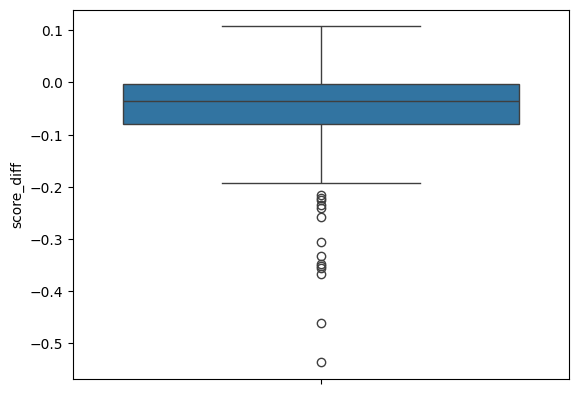

In [124]:
sns.boxplot(
    casanovo_merged_df.loc[
        ~casanovo_merged_df["match"],
        "score_diff"    
    ]
)

In [137]:
casanovo_merged_df.sort_values("score_diff")[["peptide", "peptide_ground_truth", "score", "pep_score", "charge", "spectrum_id"]]

,peptide,peptide_ground_truth,score,pep_score,charge,spectrum_id
202,DATVTVSSASPTSPK,DFEDYGGNCDAAK,0.938785,0.402432,2,controllerType=0 controllerNumber=1 scan=8148
185,VDDVDTATNYAN,GVDEMSVEEYR,0.975990,0.515649,2,controllerType=0 controllerNumber=1 scan=7889
305,PTEDLTAR,TPETDLAR,0.866870,0.500334,2,controllerType=0 controllerNumber=1 scan=10566
181,FLPEKGSHALVGTEK,HKPDGSLAFAENPPK,0.835200,0.478914,3,controllerType=0 controllerNumber=1 scan=7866
5,GSQTVSYTR,QASADSYTR,0.973162,0.622101,2,controllerType=0 controllerNumber=1 scan=5384
...,...,...,...,...,...,...
92,GQVLAAPGGVKEHLK,GQVLAAPGSLKPHTK,0.831633,0.877700,3,controllerType=0 controllerNumber=1 scan=6712
236,DLYGAHGNYVGVLSK,DLLGAHNMHVGVLSK,0.761667,0.814871,3,controllerType=0 controllerNumber=1 scan=8534
409,FSPDAEVMLLPFLDWR,TSVAWSFNATPSVDDWR,0.758169,0.829959,2,controllerType=0 controllerNumber=1 scan=15014
249,FLRDFDPMRPR,LHVGHYVGSLSER,0.598586,0.682633,3,controllerType=0 controllerNumber=1 scan=8868


In [133]:
from denovo_utils.analysis.visualization import plot_spectrum

In [143]:
str(peak_path[0])

'/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F01_Fraction1.mgf'

In [146]:
from spectrum_utils.plot import mirror

<Axes: title={'center': 'TOP SAGE: QASADSYTR (0.62)\nBOT CASA: GSQTVSYTR (0.97)'}, xlabel='m/z', ylabel='Intensity'>

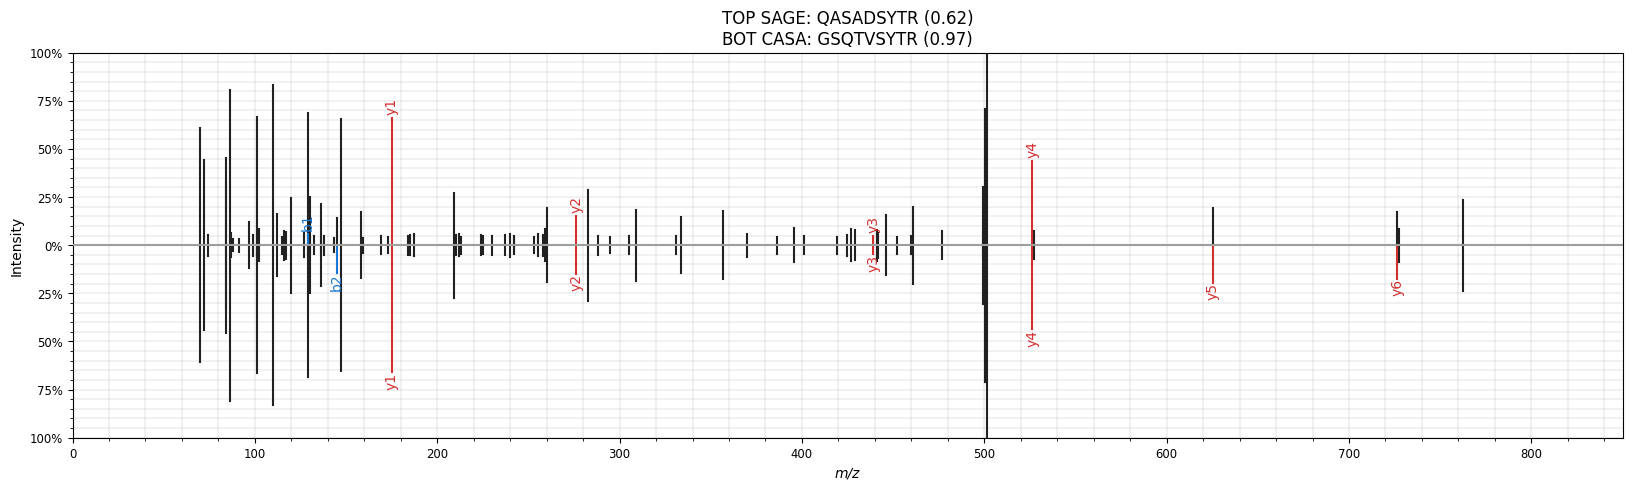

In [200]:
# EXAMPLE OF INTENSITIES BEING IMPORTANT AND NOT MZ

i=5
row = casanovo_merged_df.loc[i, ["peptidoform_x", "peptidoform_y", "peptide", "peptide_ground_truth", "score", "pep_score", "charge", "spectrum_id"]]
spec_id = row["spectrum_id"]
pep_sage = row["peptide_ground_truth"]
pep_casa = row["peptide"]

plt.figure(figsize=(20,5))
plt.title("TOP SAGE: {} ({:.2f})\nBOT CASA: {} ({:.2f})".format(
    pep_sage, row['pep_score'], pep_casa, row['score']
))
spec_sage = plot_spectrum(
    mgf_path=str(peak_path[0]),
    spectrum_id=spec_id,
    peptide=row["peptidoform_y"].proforma,
    plot=False
)

spec_casa = plot_spectrum(
    mgf_path=str(peak_path[0]),
    spectrum_id=spec_id,
    peptide=row["peptidoform_x"].proforma,
    plot=False
)
mirror(spec_sage, spec_casa)

In [201]:
from ms2pip.core import predict_single, correlate
from psm_utils import PSM, PSMList
import logging

logger = logging.getLogger()
logger.disabled=True

In [202]:
correlation_sage = correlate(
    PSMList(
        psm_list=[PSM(
            peptidoform=row["peptidoform_y"],
            spectrum_id=row["spectrum_id"],
        )]
    ),
    spectrum_file=str(peak_path[0]),
    compute_correlations=True
)[0].correlation
correlation_casa = correlate(
    PSMList(
        psm_list=[PSM(
            peptidoform=row["peptidoform_x"],
            spectrum_id=row["spectrum_id"],
        )]
    ),
    spectrum_file=str(peak_path[0]),
    compute_correlations=True
)[0].correlation

print("Corr sage: {:.5f}\nCorr casa: {:.5f}".format(correlation_sage, correlation_casa))

INFO: Processing spectra and peptides...
INFO: Processing spectra and peptides...


INFO: Computing correlations
INFO: Computing correlations
INFO: Median correlation: 0.40941604620938743
INFO: Median correlation: 0.40941604620938743
INFO: Processing spectra and peptides...
INFO: Processing spectra and peptides...


INFO: Computing correlations
INFO: Computing correlations
INFO: Median correlation: 0.8560895348739299
INFO: Median correlation: 0.8560895348739299


Corr sage: 0.40942
Corr casa: 0.85609


In [191]:
row["peptidoform_y"]

Peptidoform('QASADSYTR/2')

In [192]:
row["peptidoform_x"]

Peptidoform('GSQTVSYTR/2')

<Axes: xlabel='m/z', ylabel='Intensity'>

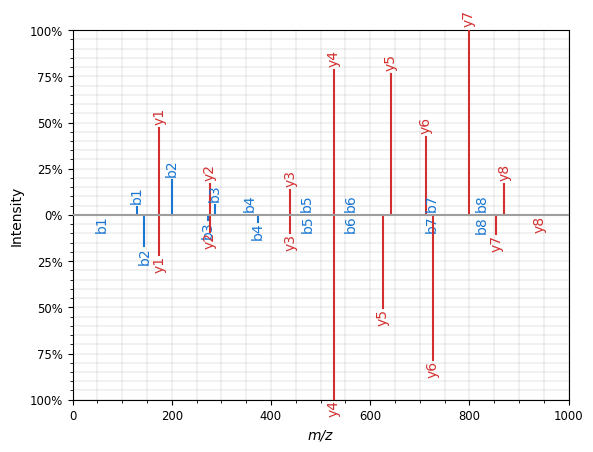

In [173]:

casa_pred = predict_single(peptidoform=row["peptidoform_y"].proforma, model="HCD2021")
sage_pred = predict_single(peptidoform=row["peptidoform_x"].proforma, model="HCD2021")

mirror(
    casa_pred.as_spectra()[0].to_spectrum_utils(), sage_pred.as_spectra()[0].to_spectrum_utils()
)

INFO: Processing spectra and peptides...
INFO: Processing spectra and peptides...


INFO: Computing correlations
INFO: Computing correlations
INFO: Median correlation: 0.8560895348739299
INFO: Median correlation: 0.8560895348739299


0.8560895348739299

In [5]:
batch_1 = dtp[0]

In [178]:
batch_1[0].shape

torch.Size([5, 96, 2])

In [183]:
for i in range(5):
    print(batch_1[1][i])

tensor([1303.7789,    2.0000,  652.8967])
tensor([1017.7997,    2.0000,  509.9071])
tensor([1275.7550,    2.0000,  638.8848])
tensor([1103.7804,    2.0000,  552.8975])
tensor([1153.7766,    2.0000,  577.8956])


In [202]:
(652.8967-1.007276)*2

1303.778848

In [228]:
spectrum = torch.zeros((1, 45, 2))
precursors = torch.tensor((1303.7789, 2.0000, 652.8967)).reshape(1,-1)

In [262]:
null_output = model_pt_interpretable.forward(
    spectra=spectrum,
    precursors=precursors,
    peptide=torch.tensor([0, ])
).detach().numpy()

pd.DataFrame(
    null_output.reshape(-1, 29)
)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,-1.083999,0.314936,0.724437,0.221901,-1.408618,0.283422,0.562670,-1.194017,0.776707,-1.083999,...,1.397954,-0.621577,-0.493057,-1.492932,-1.507707,-0.029498,-1.671966,-1.856079,-1.182756,-0.909155
1,-3.041476,1.241956,-0.080683,0.711424,2.054940,-1.083351,1.171962,-0.984495,0.156972,-3.041476,...,0.617403,0.469011,0.386810,-1.952915,-2.552636,-2.648755,-3.341247,-3.272813,-3.031312,-2.631928
2,-3.224735,1.672910,0.499958,0.765178,2.572323,-0.351324,1.258055,0.184133,0.741869,-3.224735,...,1.095674,0.986523,0.658072,-2.259794,-3.095565,-2.750351,-3.244980,-3.438476,-3.171577,-2.901183


In [263]:
model_pt.decoder._aa2idx

{'G': 1,
 'A': 2,
 'S': 3,
 'P': 4,
 'V': 5,
 'T': 6,
 'C+57.021': 7,
 'L': 8,
 'I': 9,
 'N': 10,
 'D': 11,
 'Q': 12,
 'K': 13,
 'E': 14,
 'M': 15,
 'H': 16,
 'F': 17,
 'R': 18,
 'Y': 19,
 'W': 20,
 'M+15.995': 21,
 'N+0.984': 22,
 'Q+0.984': 23,
 '+42.011': 24,
 '+43.006': 25,
 '-17.027': 26,
 '+43.006-17.027': 27,
 '$': 28}

In [260]:
pd.DataFrame(
    null_output.reshape(-1, 29)
).T

,0,1,2
0,-1.083999,-3.041476,-3.224735
1,0.314936,1.241956,1.672910
2,0.724437,-0.080683,0.499958
3,0.221901,0.711424,0.765178
4,-1.408618,2.054940,2.572323
5,0.283422,-1.083351,-0.351324
6,0.562670,1.171962,1.258055
7,-1.194017,-0.984495,0.184133
8,0.776707,0.156972,0.741869
9,-1.083999,-3.041476,-3.224735


In [254]:
batch_1[1][1]

tensor([1017.7997,    2.0000,  509.9071])

In [256]:
output_1 =  model_pt_interpretable.forward(
    spectra=batch_1[0][0].reshape(1, -1, 2),
    precursors=batch_1[1][0].reshape(1, -1),
    peptide=None
).detach().numpy()

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: >

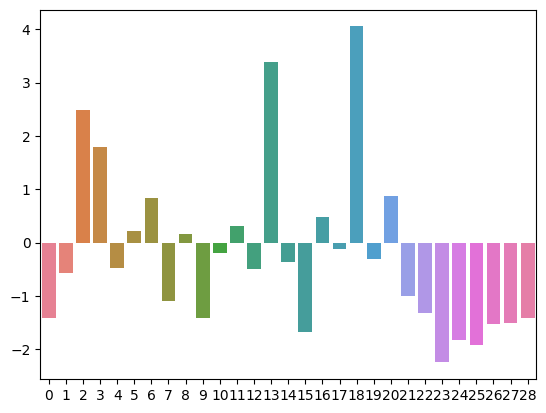

In [257]:
sns.barplot(
    pd.DataFrame(
        output_1.reshape(-1, 29)
    )
)

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: >

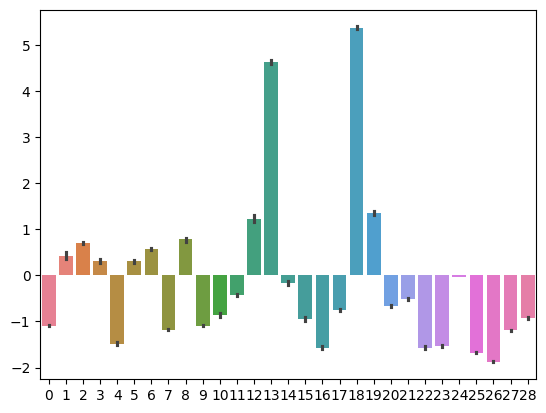

In [251]:
sns.barplot(
    pd.DataFrame(
        null_output.reshape(-1, 29)[:-1]
    )
)

In [219]:
null_output.flatten()

array([9.6367876e-04, 3.9037424e-03, 5.8792606e-03, 3.5569277e-03,
       6.9654844e-04, 3.7826230e-03, 5.0011501e-03, 8.6328178e-04,
       6.1947424e-03, 9.6367876e-04, 1.2370778e-03, 1.7982251e-03,
       9.9111442e-03, 2.9866236e-01, 2.4079946e-03, 1.0858697e-03,
       6.0541247e-04, 1.3116784e-03, 6.2933552e-01, 1.1529959e-02,
       1.5302335e-03, 1.7401036e-03, 6.4022862e-04, 6.3084072e-04,
       2.7662730e-03, 5.3528161e-04, 4.4526835e-04, 8.7305735e-04,
       1.1477988e-03], dtype=float32)

In [203]:
batch_1[0][1].shape

torch.Size([96, 2])

In [31]:
tokens = list(reversed(model_pt.decoder.detokenize(
    np.array(list(range(29)))
)))

def get_aa_probability_table(model, spectra, precursors, peptide, tokens):
    peptide_tokens = list(reversed(model.decoder.detokenize(model.decoder.tokenize(peptide))))

    prediction_scores = model.forward(
        spectra=spectra,
        precursors=precursors,
        peptide=peptide
    ).detach().numpy()
    return pd.DataFrame(
        prediction_scores.reshape(-1, 29),
        columns=tokens,
        index=peptide_tokens
    )

In [79]:
def combine_inputs(
        spectra,
        precursors,
        peptide
):
    # Flatten the tensors
    input1_flat = spectra.view(-1)  # Flatten to (1 * 150 * 2)
    input2_flat = precursors.view(-1)  # Flatten to (1 * 3)
    input3_flat = peptide.view(-1)  # Flatten to (13)
    
    # Create a padding marker
    padding = torch.tensor([float('inf')])  # Using inf as a delimiter
    
    # Concatenate with padding in between
    combined_tensor = torch.cat([input1_flat, padding, input2_flat, padding, input3_flat], dim=0)
    
    return combined_tensor

In [117]:
peptide = "SAVESGSAAGTR"
peptide_tokens = model_pt.decoder.tokenize(peptide)
combined_input = combine_inputs(
    spectra=dtp[135][0],
    precursors=dtp[135][1],
    peptide=peptide_tokens
)

In [153]:
spectra_, precursors_, peptide_ = model_pt_interpretable.decompose_inputs(
    combined_input
)

torch.Size([318]) torch.Size([300]) torch.Size([3]) torch.Size([13])


In [134]:
output = model_pt_interpretable.forward(combined_input)

13 tensor([18.,  6.,  1.,  2.,  2.,  3.,  1.,  3., 14.,  5.,  2.,  3., 28.])


In [126]:
len(output.reshape(-1, 29).detach().numpy())

14

In [107]:
peptide_tokens.tolist()

[18, 6, 1, 2, 2, 3, 1, 3, 14, 5, 2, 3, 28]

In [114]:
len(model_pt.decoder.detokenize(peptide_tokens))

13

<Axes: >

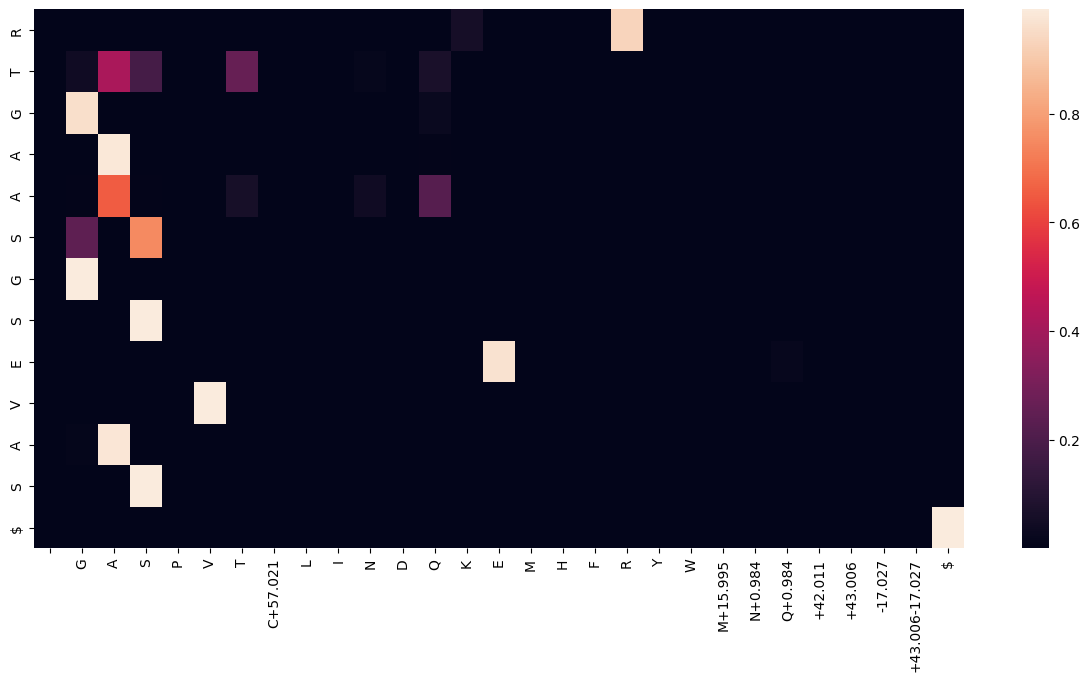

In [130]:
tokens = list(reversed(model_pt.decoder.detokenize(
    np.array(list(range(29)))
)))

plt.figure(figsize=(15,7))
sns.heatmap(
    pd.DataFrame(
        output.reshape(-1, 29).detach().numpy()[:-1],
        columns=tokens,
        index=list(reversed(model_pt.decoder.detokenize(peptide_tokens)))
    )
)

In [170]:
ig = IntegratedGradients(model_pt_interpretable)

In [171]:
attr, delta = ig.attribute(
    (dtp[135][0], dtp[135][1], peptide_tokens), target=0, return_convergence_delta=True
)

IndexError: index out of range in self

In [32]:
prediction_table = get_aa_probability_table(
    model=model_pt_interpretable,
    spectra=dtp[135][0],
    precursors=dtp[135][1],
    peptide = "SAVESGSAAGTR",
    tokens=tokens
)

In [78]:
prediction_scores = model_pt_interpretable.forward(
    spectra=dtp_1[0],
    precursors=dtp_1[1],
    peptide = "DVSSSHSSSTQDA"
).detach().numpy()

[tensor([ 2, 11, 12,  6,  3,  3,  3, 16,  3,  3,  3,  5, 11])]


Text(0.5, 1.0, 'SAVESGSAAGTR')

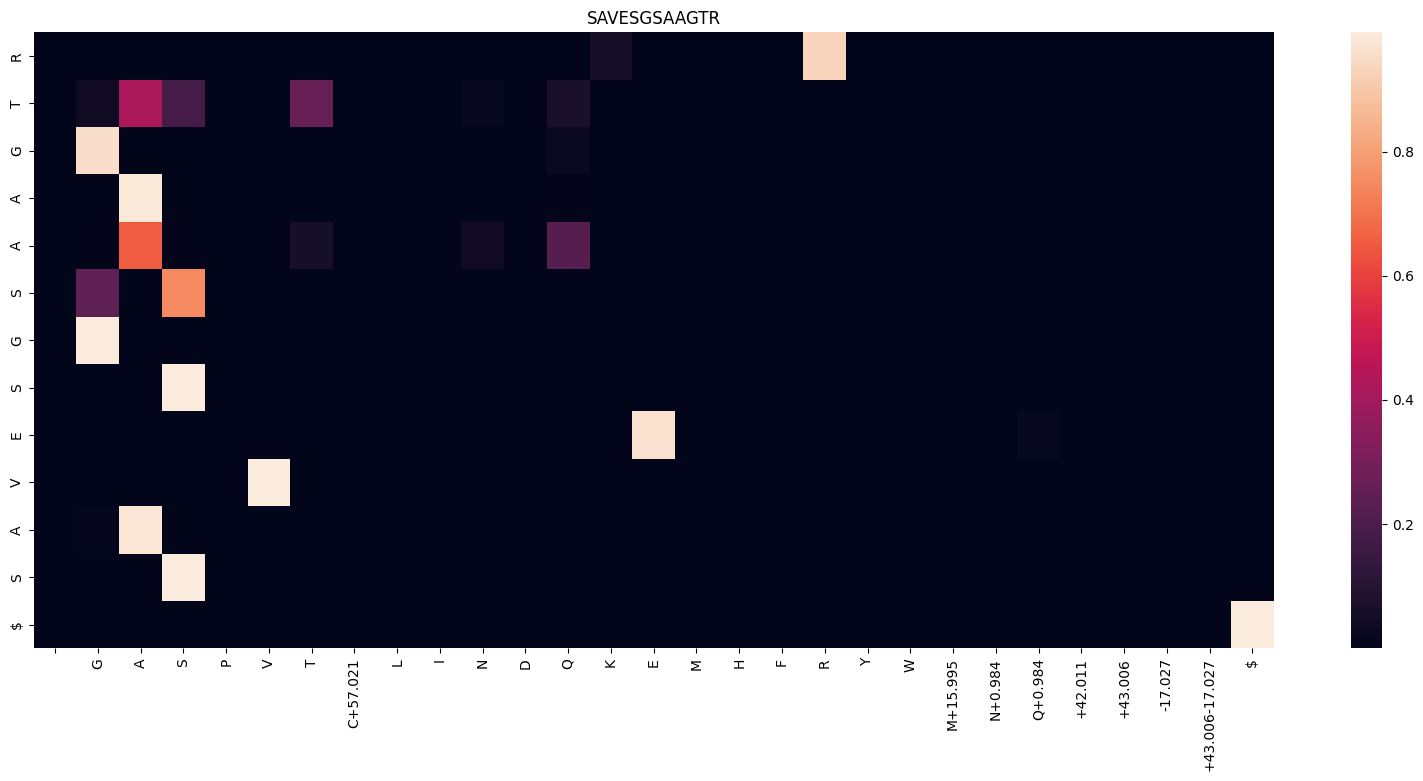

In [34]:
peptide = "SAVESGSAAGTR"
prediction_table = get_aa_probability_table(
    model=model_pt_interpretable,
    spectra=dtp[135][0],
    precursors=dtp[135][1],
    peptide = peptide,
    tokens=tokens
)

plt.figure(figsize=(20,8))
sns.heatmap(
    prediction_table
)
plt.title(peptide)

Text(0.5, 1.0, 'SAVESGSAAASR')

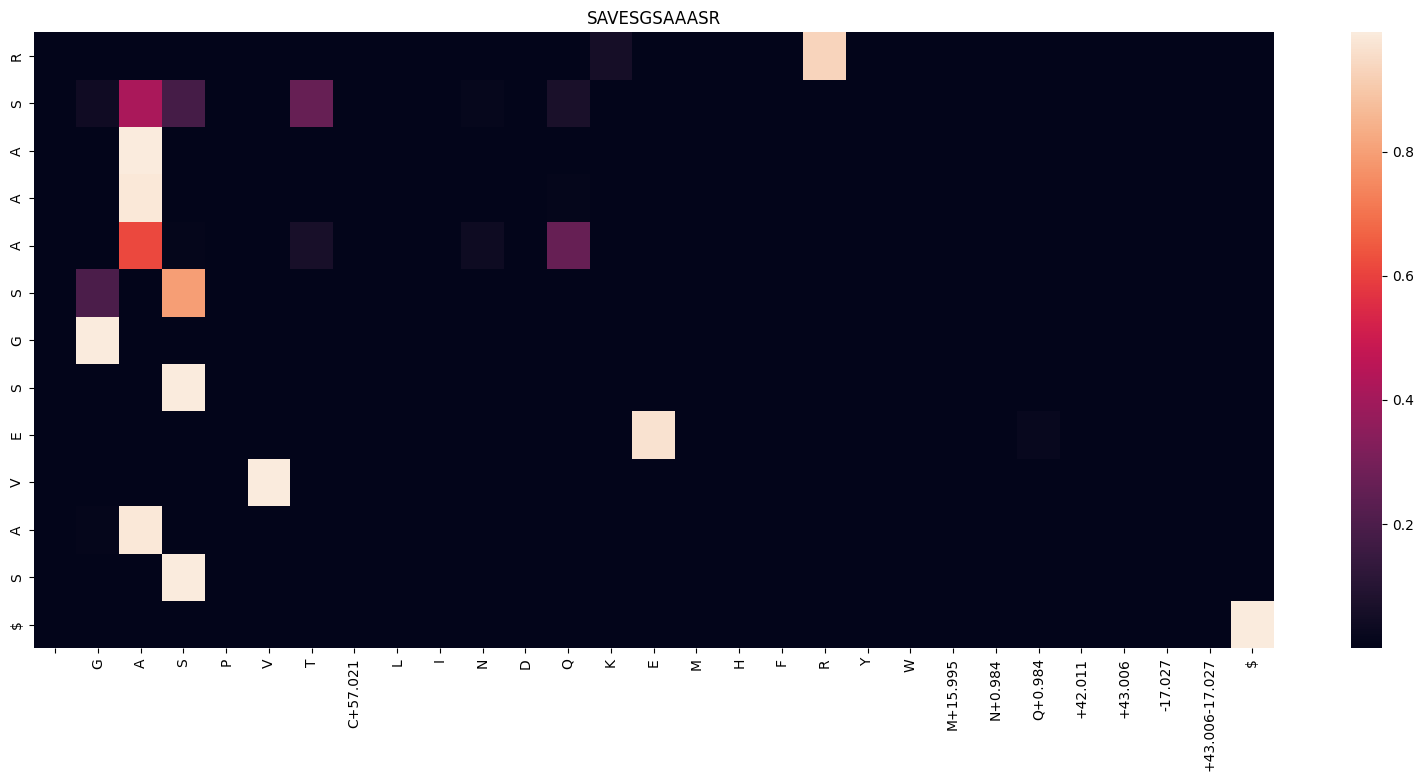

In [36]:
peptide = "SAVESGSAAASR"
prediction_table = get_aa_probability_table(
    model=model_pt_interpretable,
    spectra=dtp[135][0],
    precursors=dtp[135][1],
    peptide = peptide,
    tokens=tokens
)

plt.figure(figsize=(20,8))
sns.heatmap(
    prediction_table
)
plt.title(peptide)

In [38]:
from captum.attr import IntegratedGradients

In [39]:
ig = IntegratedGradients(
    model_pt_interpretable
)

In [ ]:
attr, delta = ig.attribute(
    test_input_tensor, target=2, return_convergence_delta=True
)